<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-1/04_card_game_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Card game: case study

Our aim is to play a card game in which the cards are iteratively flipped until we tell
the dealer to stop. Then one additional card is flipped. If that card is red, we win a
dollar; otherwise, we lose a dollar.

Our goal is to discover a strategy that best predicts
a red card in the deck.

We will do so by

1. Developing multiple strategies for predicting red cards in a randomly shuffled deck.
2. Applying each strategy across multiple simulations to compute its probability of success within a high confidence interval.
3. Returning the simplest strategy associated with the highest probability of
success.



##Setup

In [1]:
!wget https://github.com/rahiakela/data-science-research-and-practice/raw/main/data-science-bookcamp/case-study-1/probabilities.py

--2022-03-25 05:46:17--  https://github.com/rahiakela/data-science-research-and-practice/raw/main/data-science-bookcamp/case-study-1/probabilities.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rahiakela/data-science-research-and-practice/main/data-science-bookcamp/case-study-1/probabilities.py [following]
--2022-03-25 05:46:17--  https://raw.githubusercontent.com/rahiakela/data-science-research-and-practice/main/data-science-bookcamp/case-study-1/probabilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3522 (3.4K) [text/plain]
Saving to: ‘probabilities.py’

probabilities.py    100%[

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

from probabilities import *

##Predicting red cards in a shuffled deck

We start by creating a deck holding 26 red cards and 26 black cards.

In [3]:
# Modeling a 52-card deck
red_cards = 26 * [1]
black_cards = 26 * [0]

unshuffled_deck = red_cards + black_cards

In [4]:
# Shuffling a 52-card deck
np.random.seed(0)

shuffled_deck = np.random.permutation(unshuffled_deck)

How do we decide when we should stop?

One simple strategy is to terminate the
game when the number of red cards remaining in the deck is greater than the number
of black cards remaining in the deck. 

Let’s execute that strategy on the shuffled deck.

In [5]:
# Coding a card game strategy
remaining_red_cards = 26

for i, card in enumerate(shuffled_deck[:-1]):
  remaining_red_cards -= card
  # Subtracts the total cards seen thus far from 52. This total equals i + 1, since i is initially set to zero
  remaining_total_cards = 52 - i - 1
  if remaining_red_cards / remaining_total_cards > 0.5:
    break

print(f"Stopping the game at index {i}.")
final_card = shuffled_deck[i + 1]
color = "red" if final_card else 0
print(f"The next card in the deck is {'red' if final_card else 'black'}.")
print(f"We have {'won' if final_card else 'lost'}!")

Stopping the game at index 0.
The next card in the deck is black.
We have lost!


Our strategy halts when the fraction of
remaining red cards is greater than half of the remaining total cards. 

We can generalize
that fraction to equal a `min_red_fraction` parameter, thus halting when the red card ratio is greater than the inputted parameter value.

In [6]:
# Generalizing the card game strategy
np.random.seed(0)

total_cards = 52
total_red_cards = 26

def execute_strategy(min_fraction_red=0.5, shuffled_deck=None, return_index=False):
  if shuffled_deck is None:
    # Shuffles the unshuffled deck
    shuffled_deck = np.random.permutation(unshuffled_deck)
  
  remaining_red_cards = total_red_cards

  for i, card in enumerate(shuffled_deck[:-1]):
    remaining_red_cards -= card
    # Subtracts the total cards seen thus far from 52. This total equals i + 1, since i is initially set to zero
    fraction_red_cards = remaining_red_cards / (total_cards - i - 1)
    if fraction_red_cards > min_fraction_red:
      break
  # Optionally returns the card index along with the final card
  return (i + 1, shuffled_deck[i + 1]) if return_index else shuffled_deck[i + 1]

###Estimating the probability of strategy success

Let’s apply our basic strategy to a series of 1,000 random shuffles.

In [7]:
# Running the strategy over 1,000 shuffles
observations = np.array([execute_strategy() for _ in range(1000)])

In [8]:
# Computing the frequency of wins
frequency_wins = observations.sum() / 1000

assert frequency_wins == observations.mean()
print(f"The frequency of wins is {frequency_wins}")

The frequency of wins is 0.511


We’ve won 51.1% of the total games!

In [9]:
# Computing total profit
dollars_won = frequency_wins * 1000
dollars_lost = (1 - frequency_wins) * 1000

total_profit = dollars_won - dollars_lost
print(f"Total profit is ${total_profit:.2f}")

Total profit is $22.00


The strategy worked well for a sample size of 1,000 shuffles. We now plot the strategy’s
win-frequency convergence over a series of sample sizes ranging from 1 through 10,000.

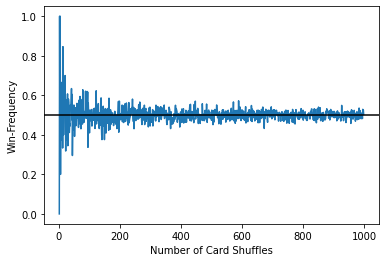

The win-frequency for 10,000 shuffles is 0.5035035035035035


In [10]:
# Plotting simulated frequencies of wins
np.random.seed(0)

def repeat_game(number_repeats):
  observations = np.array([execute_strategy() for _ in range(number_repeats)])
  return observations.mean()

frequencies = []
for i in range(1, 1000):
  frequencies.append(repeat_game(i))

plt.plot(list(range(1, 1000)), frequencies)
plt.axhline(0.5, color="k")
plt.xlabel("Number of Card Shuffles")
plt.ylabel("Win-Frequency")
plt.show()

print(f"The win-frequency for 10,000 shuffles is {frequencies[-1]}")

The strategy yields a win frequency of over 50% when 10,000 card shuffles are sampled.
However, the strategy also fluctuates above and below 50% throughout the
entire sampling process.

How confident are we that the probability of a win is actually
greater than 0.5?

We can find out using confidence interval analysis.We
compute the confidence interval by sampling 10,000 card shuffles 300 times, for a
total of 3 million shuffles.

The frequency range 0.488938 - 0.509494 represents a 97.00% confidence interval


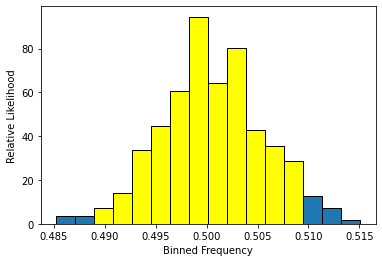

In [12]:
# Computing the confidence interval for 3 million shuffles
np.random.seed(0)

frequency_array = np.array([repeat_game(10000) for _ in range(300)])
likelihoods, bin_edges, patches = plt.hist(frequency_array, bins="auto", edgecolor="black", density=True)
bin_width = bin_edges[1] - bin_edges[0]
start_index, end_index = compute_high_confidence_interval(likelihoods, bin_width, bin_edges) 

for i in range(start_index, end_index):
  patches[i].set_facecolor("yellow")
plt.xlabel("Binned Frequency")
plt.ylabel("Relative Likelihood")
plt.show()

We are quite confident that the actual probability lies somewhere between 0.488 and
0.509. However, we still don’t know whether that probability is above 0.5 or below 0.5.

This is a problem: even a minor misinterpretation of the true probability could cause
us to lose money.

We must be absolutely certain that the true probability lies above 0.5. Thus, we
must narrow the 95% confidence interval by increasing the sample size at the expense
of running time.

The frequency range 0.495601 - 0.504345 represents a 96.03% confidence interval


(11, 32)

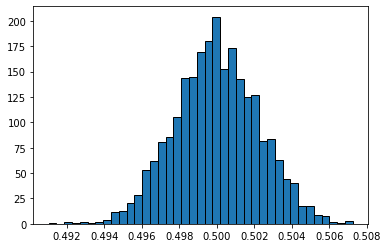

In [13]:
# Computing the confidence interval for 150 million shuffles
np.random.seed(0)

frequency_array = np.array([repeat_game(50000) for _ in range(3000)])
likelihoods, bin_edges, patches = plt.hist(frequency_array, bins="auto", edgecolor="black", density=True)
bin_width = bin_edges[1] - bin_edges[0]
compute_high_confidence_interval(likelihoods, bin_width, bin_edges) 

Unfortunately, the new confidence interval still does
not discern whether the true probability lies above 0.5.

Increasing
the number of samples is not computationally feasible.
Perhaps increasing min_red_fraction from
0.5 to 0.75 will yield an improvement. 

Let’s update our strategy and go for a long walk
as our simulation takes another hour to run.

In [ ]:
# Computing the confidence interval for an updated strategy
np.random.seed(0)

def repeat_game(number_repeats, min_red_fraction):
  observations = np.array([execute_strategy(min_red_fraction) for _ in range(number_repeats)])
  return observations.mean()

frequency_array = np.array([repeat_game(50000, 0.75) for _ in range(3000)])
likelihoods, bin_edges, patches = plt.hist(frequency_array, bins="auto", edgecolor="black", density=True)
bin_width = bin_edges[1] - bin_edges[0]
compute_high_confidence_interval(likelihoods, bin_width, bin_edges) 

Nope! The span of our confidence interval remains unresolved since it still covers
both profitable and unprofitable probabilities.

Perhaps we can gain more insight by applying our strategies to a 10-card deck.

##Optimizing strategies